### Problem: We are given information about a subset of the Titanic population and asked to build a predictive model that tells us whether or not a given passenger survived the shipwreck. We are given 10 basic explanatory variables, including passenger gender, age, and price of fare, among others. This is a classic binary classification problem, and we will be implementing a random forest classifer.

#### Data: Kaggle - Titanic: Machine Learning from Disaster https://www.kaggle.com/c/titanic

There is a huge difference between classifiers and regressors. Classifiers predict one class from a predetermined list or probabilities of belonging to a class. Regressors predict some value, which could be almost anything.
Different metrics are used for classification and regression.
#### Difference between a Classifier and a Regressor.
A <b>Classifier</b> is used to predict a set of specified labels - The simplest( and most hackneyed) example being that of Email Spam Detection where we will always want to classify whether an email is either spam (1) or not spam(0) .  So each email will get either a 0 or 1 or maybe even a fraction(if you go ahead and decide to predict the probability of an email being spam. 
<br />
Examples : Classifying movie reviews based on text, Detecting the presence of seizures from recorded EEG signals, Classifying whether a passenger would survive in the Titanic disaster.
<br /><br />
On the other hand a <b>Regressor</b> is used to predict real valued outputs which vary and dont require outputs predicted to be in a fixed set. For example when wanting to predict the future income of restaurants, we really dont know all the possible outputs.
<br />
Examples : Predicting future Elo ratings of Chess players, Predicting the runs scored by a team in a cricket match

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Data Inspections

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
total = train.isnull().sum().sort_values(ascending=False)
percent_1 = train.isnull().sum()/train.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head()

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


The Embarked feature has only 2 missing values, which can easily be filled. It will be much more tricky, to deal with the 'Age' feature, which has 177 missing values. The 'Cabin' feature needs further investigation, but it looks like that we might want to drop it from the dataset, since 77 % of it are missing.

In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Above we can see that 38% out of the training-set survived the Titanic. We can also see that the passenger ages range from 0.4 to 80. 

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Survived column is already binary format. Name, Sex, Ticket, Cabin,and Embarked need further adaptation.

### Survived

In [6]:
train['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

So we can see that 62% of the people in the training set died. This is slightly less than the estimated 67% that died in the actual shipwreck (1500/2224).

### Pclass

In [7]:
train['Survived'].groupby(train['Pclass']).mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

Class played a critical role in survival, the survival rate decreased drastically for the lowest class. This variable is both useful and clean, and is categorical variable.

### Name & Title

The Name column as provided cannot be used in the model. However, we might be able to extract some meaningful information from it. First, we can obtain useful information about the passenger's title. Looking at the distribution of the titles, it might be useful to group the smaller sized values into an 'other' group, but this example we don't do it. 

In [8]:
train['Name_Title'] = train['Name'].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])
train['Name_Title'].value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Mlle.          2
Major.         2
Col.           2
Lady.          1
Sir.           1
Capt.          1
Mme.           1
Don.           1
the            1
Jonkheer.      1
Ms.            1
Name: Name_Title, dtype: int64

In [9]:
train['Survived'].groupby(train['Name_Title']).mean()

Name_Title
Capt.        0.000000
Col.         0.500000
Don.         0.000000
Dr.          0.428571
Jonkheer.    0.000000
Lady.        1.000000
Major.       0.500000
Master.      0.575000
Miss.        0.697802
Mlle.        1.000000
Mme.         1.000000
Mr.          0.156673
Mrs.         0.792000
Ms.          1.000000
Rev.         0.000000
Sir.         1.000000
the          1.000000
Name: Survived, dtype: float64

the survival rate appears to be either significantly above or below the average survival rate, this variable should be able to help our model.

### Sex

In [10]:
train['Sex'].value_counts(normalize=True)

male      0.647587
female    0.352413
Name: Sex, dtype: float64

In [11]:
train['Survived'].groupby(train['Sex']).mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

"Women and children first," goes the famous saying. Thus, we should expect females to have a higher survival rate than males, and indeed that is the case. We expect this variable to be very useful in our model.

### Age

In [12]:
train['Survived'].groupby(train['Age'].isnull()).mean()

Age
False    0.406162
True     0.293785
Name: Survived, dtype: float64

In [13]:
train['Survived'].groupby(pd.qcut(train['Age'],5)).mean()

Age
(0.419, 19.0]    0.481707
(19.0, 25.0]     0.328467
(25.0, 31.8]     0.393701
(31.8, 41.0]     0.437500
(41.0, 80.0]     0.373239
Name: Survived, dtype: float64

In [14]:
pd.qcut(train['Age'],5).value_counts()

(0.419, 19.0]    164
(31.8, 41.0]     144
(41.0, 80.0]     142
(19.0, 25.0]     137
(25.0, 31.8]     127
Name: Age, dtype: int64

Upon first glance, the relationship between age and survival appears to be a murky one at best. However, this doesn't mean that the variable will be a bad predictor; at deeper levels of a given decision tree, a more discriminant relationship might open up.

### SibSp

In [15]:
train['Survived'].groupby(train['SibSp']).mean()

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64

In [16]:
train['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

Upon first glance, the importance of this variable is not too convincing. The distribution and survival rate between the different categories does not provide much hope.

### Parch

In [17]:
train['Survived'].groupby(train['Parch']).mean()

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64

In [18]:
train['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

passengers with zero parents or children had a lower likelihood of survival than otherwise, but that survival rate was only slightly less than the overall population survival rate.

When we have two seemingly weak predictors, one thing we can do is combine them to get a stronger predictor. In the case of SibSp and Parch, we can combine the two variables to get a 'family size' metric, which might (and in fact does) prove to be a better predictor than the two original variables.

### Ticket

The Ticket column seems to contain unique alphanumeric values, and is thus not very useful on its own. However, we might be able to extract come predictive power from it.

In [19]:
train['Ticket'].head(n=10)

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
5              330877
6               17463
7              349909
8              347742
9              237736
Name: Ticket, dtype: object

One piece of potentially useful informatin is the number of characters in the Ticket column. This could be a reflection of the 'type' of ticket a given passenger had, which could somehow indicate their chances of survival. One theory (which may in fact be verifiable) is that some characteristic of the ticket could indicate the location of the passenger's room, which might be a crucial factor in their escape route, and consequently their survival.

In [20]:
train['Ticket_Len'] = train['Ticket'].apply(lambda x: len(x))

In [21]:
train['Ticket_Len'].value_counts()

6     419
5     131
4     101
8      76
10     41
7      27
9      26
17     14
16     11
13     10
12     10
15      9
11      8
18      6
3       2
Name: Ticket_Len, dtype: int64

Another piece of information is the first letter of each ticket, which, again, might be indicative of a certain attribute of the ticketholders or their rooms.

In [22]:
train['Ticket_Letter'] = train['Ticket'].apply(lambda x: str(x)[0])

In [23]:
train['Ticket_Letter'].value_counts()

3    301
2    183
1    146
S     65
P     65
C     47
A     29
W     13
4     10
7      9
F      7
6      6
L      4
5      3
8      2
9      1
Name: Ticket_Letter, dtype: int64

In [24]:
train.groupby(['Ticket_Letter'])['Survived'].mean()

Ticket_Letter
1    0.630137
2    0.464481
3    0.239203
4    0.200000
5    0.000000
6    0.166667
7    0.111111
8    0.000000
9    1.000000
A    0.068966
C    0.340426
F    0.571429
L    0.250000
P    0.646154
S    0.323077
W    0.153846
Name: Survived, dtype: float64

### Fare

In [25]:
pd.qcut(train['Fare'], 3).value_counts()

(-0.001, 8.662]    308
(26.0, 512.329]    295
(8.662, 26.0]      288
Name: Fare, dtype: int64

In [26]:
train['Survived'].groupby(pd.qcut(train['Fare'], 3)).mean()

Fare
(-0.001, 8.662]    0.198052
(8.662, 26.0]      0.402778
(26.0, 512.329]    0.559322
Name: Survived, dtype: float64

There is a clear relationship between Fare and Survived.

In [27]:
pd.crosstab(pd.qcut(train['Fare'], 5), columns=train['Pclass'])

Pclass,1,2,3
Fare,,,
"(-0.001, 7.854]",6,6,167
"(7.854, 10.5]",0,24,160
"(10.5, 21.679]",0,80,92
"(21.679, 39.688]",64,64,52
"(39.688, 512.329]",146,10,20


There is a clear relationship between Fare and Class too.

### Cabin

This column has the most nulls (almost 700), but we can still extract information from it, like the first letter of each cabin, or the cabin number. The usefulness of this column might be similar to that of the Ticket variable.

#### Cabin letter

We can see that most of the cabin letters are associated with a high survival rate, so this might very well be a useful variable. Because there aren't that many unique values, we won't do any grouping here, even if some of the values have a small count.

In [28]:
train['Cabin_Letter'] = train['Cabin'].apply(lambda x: str(x)[0])

In [29]:
train['Cabin_Letter'].value_counts()

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin_Letter, dtype: int64

In [30]:
train['Survived'].groupby(train['Cabin_Letter']).mean()

Cabin_Letter
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
T    0.000000
n    0.299854
Name: Survived, dtype: float64

#### Cabin Number

Upon first glance, this appears to be useless. Not only do we have ~700 nulls which will be difficult to impute, but the correlation with Survived is almost zero. However, the cabin numbers as a whole do seem to have a high surival rate compared to the population average, so we might want to keep this just in case for now.

In [31]:
train['Cabin_num'] = train['Cabin'].apply(lambda x: str(x).split(' ')[-1][1:])
train['Cabin_num'].replace('an', np.NaN, inplace = True)
train['Cabin_num'] = train['Cabin_num'].apply(lambda x: int(x) if not pd.isnull(x) and x != '' else np.NaN)

In [32]:
pd.qcut(train['Cabin_num'],3).value_counts()

(65.667, 148.0]     67
(1.999, 28.667]     67
(28.667, 65.667]    66
Name: Cabin_num, dtype: int64

In [33]:
train['Survived'].groupby(pd.qcut(train['Cabin_num'], 3)).mean()

Cabin_num
(1.999, 28.667]     0.716418
(28.667, 65.667]    0.651515
(65.667, 148.0]     0.641791
Name: Survived, dtype: float64

In [34]:
train['Survived'].corr(train['Cabin_num'])

-0.06384595922789371

### Embarked
Looks like the Cherbourg people had a 20% higher survival rate than the other embarking locations. This is very likely due to the high presence of upper-class passengers from that location.

In [35]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [36]:
train['Embarked'].value_counts(normalize=True)

S    0.724409
C    0.188976
Q    0.086614
Name: Embarked, dtype: float64

In [37]:
train['Survived'].groupby(train['Embarked']).mean()

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

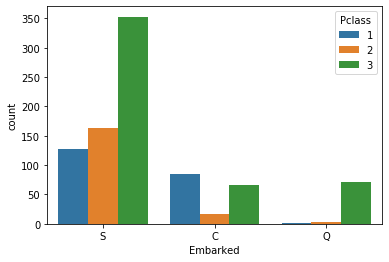

In [38]:
sns.countplot(train['Embarked'], hue=train['Pclass'])

### Feature Engineering

Having done our cursory exploration of the variables, we now have a pretty good idea of how we want to transform our variables in preparation for our final dataset. We will perform our feature engineering through a series of helper functions that each serve a specific purpose.

This first function creates two separate columns: a numeric column indicating the length of a passenger's Name field, and a categorical column that extracts the passenger's title.

In [39]:
def names(train, test):
    for i in [train, test]:
        i['Name_Len'] = i['Name'].apply(lambda x: len(x))
        i['Name_Title'] = i['Name'].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])
        del i['Name']
    return train, test

Next, we impute the null values of the Age column by filling in the mean value of the passenger's corresponding title and class. This more granular approach to imputation should be more accurate than merely taking the mean age of the population.

In [40]:
def age_impute(train, test):
    for i in [train, test]:
        i['Age_Null_Flag'] = i['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
        data = train.groupby(['Name_Title', 'Pclass'])['Age']
        i['Age'] = data.transform(lambda x: x.fillna(x.mean()))
    return train, test

We combine the SibSp and Parch columns into a new variable that indicates family size, and group the family size variable into three categories.

In [41]:
def fam_size(train, test):
    for i in [train, test]:
        i['Fam_Size'] = np.where((i['SibSp']+i['Parch']) == 0 , 'Solo',
                           np.where((i['SibSp']+i['Parch']) <= 3,'Nuclear', 'Big'))
        del i['SibSp']
        del i['Parch']
    return train, test

The Ticket column is used to create two new columns: Ticket_Letter, which indicates the first letter of each ticket (with the smaller-n values being grouped based on survival rate); and Ticket_Len, which indicates the length of the Ticket field.

In [42]:
def ticket_grouped(train, test):
    for i in [train, test]:
        i['Ticket_Letter'] = i['Ticket'].apply(lambda x: str(x)[0])
        i['Ticket_Letter'] = i['Ticket_Letter'].apply(lambda x: str(x))
        i['Ticket_Letter'] = np.where((i['Ticket_Letter']).isin(['1', '2', '3', 'S', 'P', 'C', 'A']), i['Ticket_Letter'],
                                   np.where((i['Ticket_Letter']).isin(['W', '4', '7', '6', 'L', '5', '8']),
                                            'Low_ticket', 'Other_ticket'))
        i['Ticket_Len'] = i['Ticket'].apply(lambda x: len(x))
        del i['Ticket']
    return train, test

The following two functions extract the first letter of the Cabin column and its number, respectively.

In [43]:
def cabin(train, test):
    for i in [train, test]:
        i['Cabin_Letter'] = i['Cabin'].apply(lambda x: str(x)[0])
        del i['Cabin']
    return train, test

In [44]:
def cabin_num(train, test):
    for i in [train, test]:
        i['Cabin_num1'] = i['Cabin'].apply(lambda x: str(x).split(' ')[-1][1:])
        i['Cabin_num1'].replace('an', np.NaN, inplace = True)
        i['Cabin_num1'] = i['Cabin_num1'].apply(lambda x: int(x) if not pd.isnull(x) and x != '' else np.NaN)
        i['Cabin_num'] = pd.qcut(train['Cabin_num1'],3)
    train = pd.concat((train, pd.get_dummies(train['Cabin_num'], prefix = 'Cabin_num')), axis = 1)
    test = pd.concat((test, pd.get_dummies(test['Cabin_num'], prefix = 'Cabin_num')), axis = 1)
    del train['Cabin_num']
    del test['Cabin_num']
    del train['Cabin_num1']
    del test['Cabin_num1']
    return train, test

We fill the null values in the Embarked column with the most commonly occuring value, which is 'S.'

In [45]:
def embarked_impute(train, test):
    for i in [train, test]:
        i['Embarked'] = i['Embarked'].fillna('S')
    return train, test

We also fill in the one missing value of Fare in our test set with the mean value of Fare from the training set (transformations of test set data must always be fit using training data).

In [46]:
test['Fare'].fillna(train['Fare'].mean(), inplace = True)

Next, because we are using scikit-learn, we must convert our categorical columns into dummy variables. The following function does this, and then it drops the original categorical columns. It also makes sure that each category is present in both the training and test datasets.

In [47]:
def dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked', 'Ticket_Lett', 'Cabin_Letter', 'Name_Title', 'Fam_Size']):
    for column in columns:
        train[column] = train[column].apply(lambda x: str(x))
        test[column] = test[column].apply(lambda x: str(x))
        good_cols = [column+'_'+i for i in train[column].unique() if i in test[column].unique()]
        train = pd.concat((train, pd.get_dummies(train[column], prefix = column)[good_cols]), axis = 1)
        test = pd.concat((test, pd.get_dummies(test[column], prefix = column)[good_cols]), axis = 1)
        del train[column]
        del test[column]
    return train, test

Our last helper function drops any columns that haven't already been dropped. In our case, we only need to drop the PassengerId column, which we have decided is not useful for our problem (by the way, I've confirmed this with a separate test). Note that dropping the PassengerId column here means that we'll have to load it later when creating our submission file.

In [48]:
def drop(train, test, bye = ['PassengerId']):
    for i in [train, test]:
        for z in bye:
            del i[z]
    return train, test

Having built our helper functions, we can now execute them in order to build our dataset that will be used in the model

In [49]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train, test = names(train, test)
train, test = age_impute(train, test)
train, test = cabin_num(train, test)
train, test = cabin(train, test)
train, test = embarked_impute(train, test)
train, test = fam_size(train, test)
test['Fare'].fillna(train['Fare'].mean(), inplace = True)
train, test = ticket_grouped(train, test)
train, test = dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked', 'Ticket_Letter',
                                                                     'Cabin_Letter', 'Name_Title', 'Fam_Size'])
train, test = drop(train, test)

In [50]:
print(len(train.columns))

45


We can see that our final dataset has 45 columns, composed of our target column and 44 predictor variables. Although highly dimensional datasets can result in high variance but let's see.

In [51]:
train.head()

,Survived,Age,Fare,Name_Len,Age_Null_Flag,"Cabin_num_(1.999, 28.667]","Cabin_num_(28.667, 65.667]","Cabin_num_(65.667, 148.0]",Ticket_Len,Pclass_3,...,Name_Title_Mrs.,Name_Title_Miss.,Name_Title_Master.,Name_Title_Rev.,Name_Title_Dr.,Name_Title_Ms.,Name_Title_Col.,Fam_Size_Nuclear,Fam_Size_Solo,Fam_Size_Big
0,0,22.0,7.2500,23,0,0,0,0,9,1,...,0,0,0,0,0,0,0,1,0,0
1,1,38.0,71.2833,51,0,0,0,1,8,0,...,1,0,0,0,0,0,0,1,0,0
2,1,26.0,7.9250,22,0,0,0,0,16,1,...,0,1,0,0,0,0,0,0,1,0
3,1,35.0,53.1000,44,0,0,0,1,6,0,...,1,0,0,0,0,0,0,1,0,0
4,0,35.0,8.0500,24,0,0,0,0,6,1,...,0,0,0,0,0,0,0,0,1,0


### Hyperparameter Tuning

https://scikit-learn.org/stable/modules/grid_search.html
<br />
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
<br />
<br />
We will use grid search to identify the optimal parameters of our random forest model. Because our training dataset is quite small, we can get away with testing a wider range of hyperparameter values. 
<br />
<br />
https://stackoverflow.com/questions/19335165/what-is-the-difference-between-cross-validation-and-grid-search
<br />
<br />
Grid search is a method to perform hyper-parameter optimisation, that is, it is a method to find the best combination of hyper-parameters (an example of an hyper-parameter is the learning rate of the optimiser), for a given model (e.g. a CNN) and test dataset. In this scenario, you have several models, each with a different combination of hyper-parameters. Each of these combinations of parameters, which correspond to a single model, can be said to lie on a point of a "grid". The goal is then to train each of these models and evaluate them e.g. using cross-validation. You then select the one that performed best.

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10], "min_samples_split" : [2, 4, 10, 12, 16], "n_estimators": [50, 100, 400, 700, 1000]}

gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)

grids = gs.fit(train.iloc[:, 1:], train.iloc[:, 0])

print(grids.best_score_)
print(grids.best_params_)
print(grids.cv_results_)

0.8383838383838383
{'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 700}
{'mean_fit_time': array([0.17648959, 0.21313572, 1.04943689, 1.92896922, 3.27158356,
       0.30650298, 0.37313422, 0.99946666, 1.6491189 , 3.22827466,
       0.23654707, 0.48973823, 0.91284553, 1.70575428, 2.59861096,
       0.16324647, 0.46974897, 1.38259411, 1.79903849, 2.64525286,
       0.17324098, 0.27318788, 1.07609932, 2.13885729, 2.67856868,
       0.16324949, 0.30983289, 0.86287252, 1.66910791, 2.88845515,
       0.29983958, 0.30317934, 0.9961338 , 1.58581956, 2.82182423,
       0.15991418, 0.44310053, 1.05277054, 1.75905935, 2.48200703,
       0.15991426, 0.35980781, 1.19935966, 2.00559489, 2.65191428,
       0.2132206 , 0.25986171, 0.98589102, 2.19573832, 3.16175405,
       0.299143  , 0.36553669, 1.05442095, 1.93540247, 3.35510977,
       0.39990934, 0.25986298, 0.87286623, 1.68909566, 2.61193705,
       0.18989881, 0.54304345, 1.24266903, 1.90313601, 2.4803133 ,
 

we can see that our optimal parameter settings are not at the endpoints of our provided values, meaning that we do not have to test more values. What else can we say about our optimal values? The min_samples_split parameter is at 10, which should help mitigate overfitting to a certain degree. This is especially good because we have a relatively large number of estimators (700), which could potentially increase our generalization error.

### Model Estimation and Evaluation

In [53]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=700,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
rf.fit(train.iloc[:, 1:], train.iloc[:, 0])
print("%.4f" % rf.oob_score_)

0.8294


We are now ready to fit our model using the optimal hyperparameters. The out-of-bag score can give us an unbiased estimate of the model accuracy, and we can see that the score is 82.94%. 

Let's take a brief look at our variable importance according to our random forest model. We can see that some of the original columns we predicted would be important in fact were, including gender, fare, and age. We also see title, name length, and ticket length features are important.  

In [54]:
pd.concat((pd.DataFrame(train.iloc[:, 1:].columns, columns = ['variable']), 
           pd.DataFrame(rf.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]

,variable,importance
12,Sex_female,0.111215
11,Sex_male,0.109769
33,Name_Title_Mr.,0.109746
1,Fare,0.088209
2,Name_Len,0.087904
0,Age,0.078651
8,Pclass_3,0.043268
35,Name_Title_Miss.,0.031292
7,Ticket_Len,0.031079
34,Name_Title_Mrs.,0.028852


last step is to predict the target variable for our test data and generate an output file

In [55]:
predictions = rf.predict(test)
predictions = pd.DataFrame(predictions, columns=['Survived'])
test = pd.read_csv('test.csv')
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv('y_test.csv', sep=",", index = False)